In [1]:
version = "v1.6.092820"

---
# Assignment 3 Part 1: Single Time Series Forecasting (50 pts)

In this assignment, we're going to practise forecasting a single time series. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress warnings
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

We will explore the same time series about **daily new COVID-19 cases globally** as we had in **Assignment 2 Part 1**. In order not to reinvent the wheel, let's import the `load_data` function you wrote previously. 

In [14]:
# Copy and paste the function you wrote in Assignment 2 Part 1 here and import any libraries necessary
# We have tried a more elegant solution by using
# from ipynb.fs.defs.assignment2_part1 import load_data
# but it doesn't work with the autograder...

def load_data():
    daily_new_cases = None
    
    # YOUR CODE HERE
    # YOUR CODE HERE
    #Read file:
    df= pd.read_csv('assets/time_series_covid19_confirmed_global.csv')
    
    #Melt dataframe for date columns: 
    df_melt = pd.melt(df, id_vars=['Province/State','Country/Region','Lat','Long'], var_name='date', value_name='confirmed')
    
    #Transform date column in to datetime object: 
    df_melt['date'] = pd.to_datetime(df_melt['date'])
    
    #Now, let's groupby data by date and get a sum of confirmed cases: 
    df_grouped_date = df_melt.groupby(['date'])['confirmed'].sum()
    
    #Ok, now to get daily cases, let's take the difference in number of confirmed cases from the previous day: 
    daily = []
    for i in range(1,len(df_grouped_date)):
        diff = df_grouped_date[i]-df_grouped_date[i-1]
        daily.append(diff)
    #Convert daily in to pandas series with df_grouped_date as index.
    #Here, the first date entry will be empty, hence ignored
    daily_new_cases = pd.Series(daily, index = df_grouped_date.index[1:])
    
    return daily_new_cases
    raise NotImplementedError()
    

In [15]:
load_data()

date
2020-01-23        99
2020-01-24       287
2020-01-25       493
2020-01-26       684
2020-01-27       809
               ...  
2020-08-17    209672
2020-08-18    255096
2020-08-19    274346
2020-08-20    267183
2020-08-21    270751
Length: 212, dtype: int64

In [4]:
# Sanity checks to make sure you have imported the correct function - no points awarded

stu_ans = load_data()

assert isinstance(stu_ans, pd.Series), "Q0: Your function should return a pd.Series. "
assert len(stu_ans) == 212, "Q0: The length of the series returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q0: The index of your series must be a pd.DatetimeIndex. "
assert (("2020-01-23" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q0: The index of your series contains an incorrect time range. "
assert not stu_ans.isna().any(), "Q0: Your series contains NaN values. "

del stu_ans

In [5]:
#View time series: 
load_data()[0:8]

date
2020-01-23      99
2020-01-24     287
2020-01-25     493
2020-01-26     684
2020-01-27     809
2020-01-28    2651
2020-01-29     588
2020-01-30    2068
dtype: int64

## Question 1: Stationarity Tests (20 pts)

Let's first try to understand whether our time series is stationary or not. Recall that a stationary time series has stable statistics, such as constant means and variances, over time. A non-stationary time series would not be very interesting to study, as it is essentially equivalent to a white noise, carrying little information. 

### Question 1a (15 pts)

One way of determining stationarity is to calculate some summary statistics. A rolling mean and a rolling standard deviation are the mean and the standard deviation over a rolling window of values. They both have the same length as the original time series. For a rolling window of size $k$, the $j$-th component of the rolling mean $\mu$ and the rolling standard deviation $\sigma$ is precisely defined as:

\begin{align}
\mu_{j} &= \frac{1}{\min(k, j)} \sum_{i = \max(1,j - k + 1)}^{j} x_{i} = \begin{cases}
\frac{1}{j} \sum_{i = 1}^{j} x_{i} & \text{if } j \leq k \\
\frac{1}{k} \sum_{i = j - k + 1}^{j} x_{i} & \text{if } j > k
\end{cases} 
\\
\sigma_{j} &= \frac{1}{\min(k, j)} \sum_{i = \max(1,j - k + 1)}^{j} \left(x_{i} - \mu_{j}\right)^{2} = \begin{cases}
\frac{1}{j} \sum_{i = 1}^{j} \left(x_{i} - \mu_{j}\right)^{2} & \text{if } j \leq k \\
\frac{1}{k} \sum_{i = j - k + 1}^{j} \left(x_{i} - \mu_{j}\right)^{2} & \text{if } j > k
\end{cases}
\end{align}

where $j \geq 1$.

Complete the function below that takes as input a time series and that calculates the rolling mean and the rolling standard deviation of the input time series. The size of the rolling window is governed by the argument `wd_size`. 

**This function should return a `tuple` of length 2, whose first component is the rolling mean as a `np.ndarray` and whose last component is the rolling standard deviation as a `np.ndarray`.**

### Testing code: 

In [6]:
#Testing for calculating rolling std.
#load_data().transform(lambda x: x.rolling(7,min_periods=1).std(ddof=0))

In [7]:
def calc_rolling_stats_test(ser, wd_size=7):
    
    #Calculate rolling mean and rolling standard deviation on time series: 
    rolling_mean = ser.rolling(window= wd_size, min_periods =1).mean().values
    
    #Applying Transformation to caluclate rolling standard deviation:
    rolling_std = ser.transform(lambda x: x.rolling(wd_size,min_periods=1).std(ddof=0)).values  
    #Store results as array:
    result = rolling_mean, rolling_std
    
    return result

In [8]:
#Test Result:
calc_rolling_stats_test(load_data(), wd_size =7)

(array([9.90000000e+01, 1.93000000e+02, 2.93000000e+02, 3.90750000e+02,
        4.74400000e+02, 8.37166667e+02, 8.01571429e+02, 1.08285714e+03,
        1.28371429e+03, 1.51485714e+03, 2.09557143e+03, 2.42285714e+03,
        2.61714286e+03, 3.06814286e+03, 3.22400000e+03, 3.49542857e+03,
        3.58442857e+03, 3.33885714e+03, 3.26871429e+03, 2.98742857e+03,
        2.51214286e+03, 4.22557143e+03, 4.64471429e+03, 4.56014286e+03,
        4.43928571e+03, 4.35728571e+03, 4.33442857e+03, 4.34614286e+03,
        2.26142857e+03, 1.41885714e+03, 1.36442857e+03, 1.10671429e+03,
        8.96571429e+02, 7.49571429e+02, 8.17714286e+02, 9.32571429e+02,
        1.03942857e+03, 1.05857143e+03, 1.34485714e+03, 1.54628571e+03,
        1.79271429e+03, 1.98157143e+03, 2.18542857e+03, 2.55200000e+03,
        2.85814286e+03, 3.08242857e+03, 3.35757143e+03, 3.70700000e+03,
        4.47328571e+03, 4.89600000e+03, 6.39085714e+03, 7.40085714e+03,
        8.42871429e+03, 9.96685714e+03, 1.15130000e+04, 1.321771

### Implementing Code: 

In [9]:
def calc_rolling_stats(ser, wd_size=7):
    """
    Takes in a series and returns the rolling mean and the rolling std for a window of size wd_size
    """
    
    rolling_mean, rolling_std = None, None
    
    # YOUR CODE HERE
    #Calculate rolling mean and rolling standard deviation on time series: 
    rolling_mean = ser.rolling(window= wd_size, min_periods =1).mean().values
    
    #Applying Transformation to calculate rolling standard deviation, ddof=0:
    rolling_std = ser.transform(lambda x: x.rolling(wd_size,min_periods=1).std(ddof=0)).values  
    #Store results as array:
    result = rolling_mean, rolling_std
    
    return result
    raise NotImplementedError()
    

In [10]:
# Autograder tests

stu_ser, wd_size = load_data(), 7
stu_ans = calc_rolling_stats(stu_ser, wd_size)

assert isinstance(stu_ans, tuple), "Q1a: Your function should return a tuple. "
assert len(stu_ans) == 2, "Q1a: The length of the tuple returned is incorrect. "
assert isinstance(stu_ans[0], np.ndarray), "Q1a: Please return the rolling mean as np.ndarray. "
assert isinstance(stu_ans[1], np.ndarray), "Q1a: Please return the rolling std as np.ndarray. "
assert len(stu_ans[0]) == len(stu_ser), "Q1a: Your rolling mean should be of the same length as your data. "
assert len(stu_ans[1]) == len(stu_ser), "Q1a: Your rolling std should be of the same length as your data. "

# Some hidden tests


del stu_ans, stu_ser, wd_size

Let's plot and see the rolling statistics together with the original time series. Is our time series stationary? Why or why not? 

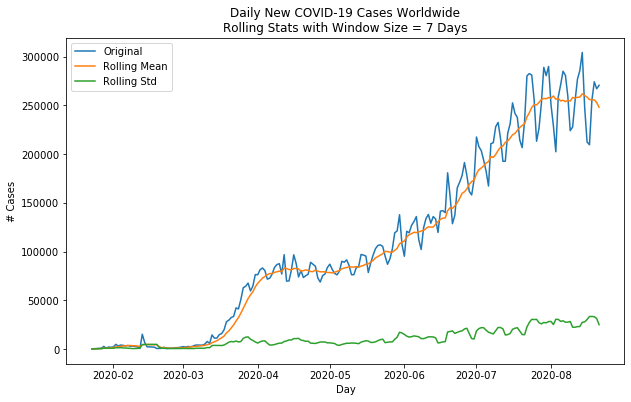

In [11]:
# Let's plot and see the rolling statistics

ser, wd_size = load_data(), 7
rolling_mean, rolling_std = calc_rolling_stats(ser, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(pd.Series(rolling_mean, index=ser.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=ser.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax, ser, wd_size, rolling_mean, rolling_std

### Question 1b (5 pts)

Now let's see whether the *log return* of our time series is stationary. Complete the function below that computes the log return of a given time series and that returns the result as a `pd.Series` like the following:

```
2020-01-24    1.064362
2020-01-25    0.541027
2020-01-26    0.327449
2020-01-27    0.167841
2020-01-28    1.186893
                ...   
2020-08-17   -0.013336
2020-08-18    0.196096
2020-08-19    0.072750
2020-08-20   -0.026456
2020-08-21    0.013266
Length: 211, dtype: float64
```

where
* the index of the series is a `pd.DatetimeIndex`; 
* the values of the series are the log returns; and
* the series doesn't contain any `NaN` values. 

**This function should return a `pd.Series`, whose index is a `pd.DatetimeIndex`.**

### Testing code: 

In [12]:
#Calculate log return on given time series: 
#Log return: y = log(yj) - log(yj-1)

In [13]:
def calc_log_ret_test(ser):
    
    #Empty list:
    log_return = []
    
    #Iterate over time series
    for i in range(1,len(ser)):
        log_return.append(np.log(ser[i])-np.log(ser[i-1]))  #Calculate log return as per formula above

    result = pd.Series(log_return, index = ser.index[1:])  
    return result
    #Note: we are calculating log return at position i using i-1  
    #Hence, we the 1.064362 belongs to i and not i-1, hence index starts after the previous value. 

In [14]:
#Test result: 
calc_log_ret_test(load_data())

date
2020-01-24    1.064362
2020-01-25    0.541027
2020-01-26    0.327449
2020-01-27    0.167841
2020-01-28    1.186893
                ...   
2020-08-17   -0.013336
2020-08-18    0.196096
2020-08-19    0.072750
2020-08-20   -0.026456
2020-08-21    0.013266
Length: 211, dtype: float64

In [15]:
def calc_log_ret(ser):
    """
    Takes in a series and computes the log return
    """
    
    log_ret = None
    
    # YOUR CODE HERE
    
    #Empty list:
    log_return = []
    
    #Iterate over time series
    for i in range(1,len(ser)):
        log_return.append(np.log(ser[i])-np.log(ser[i-1]))  #Calculate log return as per formula above

    result = pd.Series(log_return, index = ser.index[1:])  
    return result
    #Note: we are calculating log return at position i using i-1  
    #Hence, we the 1.064362 belongs to i and not i-1, hence index starts after the previous value. 
    raise NotImplementedError()
    

In [16]:
# Autograder tests

stu_ser = load_data()
stu_ans = calc_log_ret(stu_ser)

assert isinstance(stu_ans, pd.Series), "Q1b: Your function should return a pd.Series. "
assert len(stu_ans) == len(stu_ser) - 1, "Q1b: The length of the series returned should be one less than that of your data. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q1b: The index of your series must be a pd.DatetimeIndex. "
assert (("2020-01-24" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q1b: The index of your series contains an incorrect time range. "
assert not stu_ans.isna().any(), "Q1b: Your series contains NaN values. "

# Some hidden tests


del stu_ans, stu_ser

This time let's plot and see the rolling statistics together with the log returns. Are the log returns of our time series stationary? Why or why not? 

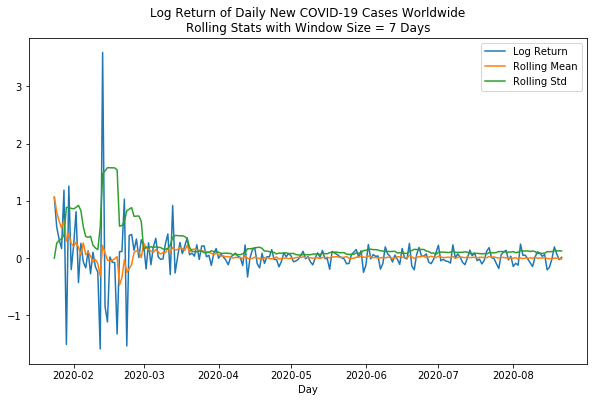

In [17]:
# Let's plot and see the rolling statistics

log_ret, wd_size = calc_log_ret(load_data()), 7
rolling_mean, rolling_std = calc_rolling_stats(log_ret, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_ret, label="Log Return")
ax.plot(pd.Series(rolling_mean, index=log_ret.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=log_ret.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_title("Log Return of Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax, log_ret, wd_size, rolling_mean, rolling_std

Answer: For first 3 months, from january to march, there is high variance in time series and so for those months log return is not stationary. Hence, I suspect that we might need to drop some data to build the forecast. 

Yet another way of determining stationarity would be to use a statistical test, such as the [Augmented Dickey-Fuller unit root test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). The null hypothesis is usually that the time series is non-stationary. A $p$-value less than $0.05$ would lead to the conclusion that the time series is stationary, although some [scientists have rised up against this magic numer](https://www.nature.com/articles/d41586-019-00857-9)!

In [18]:
# An example of performing an Augmented Dickey-Fuller unit root test

from statsmodels.tsa.stattools import adfuller

_, pval, *_ = adfuller(load_data())
print(f"p-value: {pval}")

del adfuller, pval

p-value: 0.67658525115441


## Question 2: Autocorrelations (10 pts)

Observations in a time series are often not isolated but rather correlated. That is, there might be a correlation between an observation $y_{t}$ and another observation $y_{t - k}$ that is $k$ time steps (or *lags*) earlier. (Partial) autocorrelations precisely capture this idea. 

### Question 2a (5 pts)

Complete the function below to calculate the **Autocorrelation Function (ACF)** of the input time series, with the maximum number of lags to consider specified by the parameter `max_lag`. You may use the `acf` function from the `statsmodels` library. 

**This function should return a `np.ndarray` of length `max_lag + 1`.**

### Testing code:

In [19]:
#Import acf pacf
from statsmodels.tsa.stattools import acf, pacf

In [20]:
#ACF Test function:
def calc_acf_test(ser, max_lag):
    
    #Apply ACF function from statsmodel:
    result = acf(ser, nlags= max_lag)
    
    return result

In [21]:
#ACF Test result:
print(len(calc_acf_test(load_data(), 30)))
calc_acf_test(load_data(), 30)

31


array([1.        , 0.97535964, 0.94724559, 0.92385736, 0.91386313,
       0.9167115 , 0.92474083, 0.92029816, 0.89570334, 0.86531167,
       0.83986903, 0.82678187, 0.82650348, 0.82935306, 0.82125569,
       0.79719604, 0.76575177, 0.74163109, 0.72568749, 0.72337754,
       0.72382142, 0.71434956, 0.68860387, 0.65799162, 0.63121293,
       0.61553004, 0.61048868, 0.60786787, 0.59472779, 0.56872414,
       0.53846277])

In [22]:
#PACF Test function:
def calc_pacf_test(ser, max_lag):
    
    #Apply ACF function from statsmodel:
    result = pacf(ser, nlags= max_lag)
    
    return result

In [23]:
print(len(calc_pacf_test(load_data(), 30)))
calc_pacf_test(load_data(), 30)

31


array([ 1.        ,  0.9799822 , -0.10339728,  0.11285624,  0.31413872,
        0.32346959,  0.24432008, -0.15533772, -0.41531656, -0.15955056,
       -0.044813  , -0.00213089,  0.06448035,  0.08746445,  0.03537415,
       -0.10067153, -0.14859595,  0.06374997, -0.14858939,  0.04486308,
        0.08109585,  0.021711  , -0.14332192, -0.06695407, -0.06122983,
        0.02371216, -0.07165237, -0.00560551, -0.02340175, -0.03582042,
        0.00696828])

### Implementing Code: 

In [24]:
from statsmodels.tsa.stattools import acf
def calc_acf(ser, max_lag):
    """
    Takes a series and calculates the ACF
    """
    
    ans_acf = None
    
    # YOUR CODE HERE
    ans_acf = acf(ser, nlags= max_lag)
    
    return ans_acf
    raise NotImplementedError()
    


In [25]:
#len(calc_acf(load_data(), 30))

In [26]:
# Autograder tests

stu_ser, max_lag = load_data(), 30
stu_ans = calc_acf(stu_ser, max_lag)

assert isinstance(stu_ans, np.ndarray), "Q2a: Your function should return a np.ndarray. "
assert len(stu_ans) == max_lag + 1, "Q2a: The length of the ACF returned is incorrect. "

# Some hidden tests


del stu_ans, stu_ser, max_lag

Let's see a plot of the ACF. 

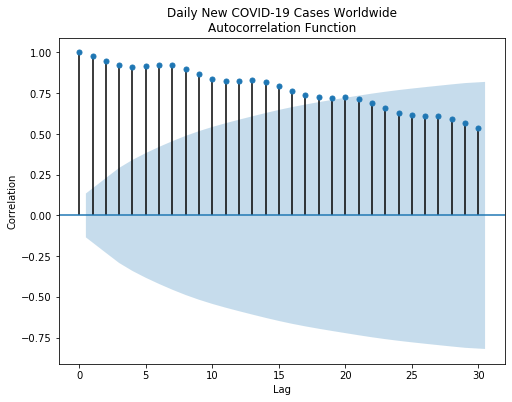

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

ser, max_lag = load_data(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(ser, ax, lags=max_lag, title="Daily New COVID-19 Cases Worldwide\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_acf

### Question 2b (5 pts)

Complete the function below to calculate the **Partial Autocorrelation Function (PACF)** of the input time series, with the maximum number of lags to consider specified by the parameter `max_lag`. You may use the `pacf` function from the `statsmodels` library. 

**This function should return a `np.ndarray` of length `max_lag + 1`.**

### Implementing Code:

In [28]:
def calc_pacf(ser, max_lag):
    """
    Takes a series and calculates the PACF
    """
    
    ans_pacf = None
    
    # YOUR CODE HERE
    #Apply ACF function from statsmodel:
    ans_pacf = pacf(ser, nlags= max_lag)
    
    return ans_pacf
    raise NotImplementedError()
    


In [29]:
# Autograder tests

stu_ser, max_lag = load_data(), 30
stu_ans = calc_pacf(stu_ser, max_lag)

assert isinstance(stu_ans, np.ndarray), "Q2b: Your function should return a np.ndarray. "
assert len(stu_ans) == max_lag + 1, "Q2b: The length of the PACF returned is incorrect. "

# Some hidden tests


del stu_ans, stu_ser, max_lag

Let's see a plot of the PACF. 

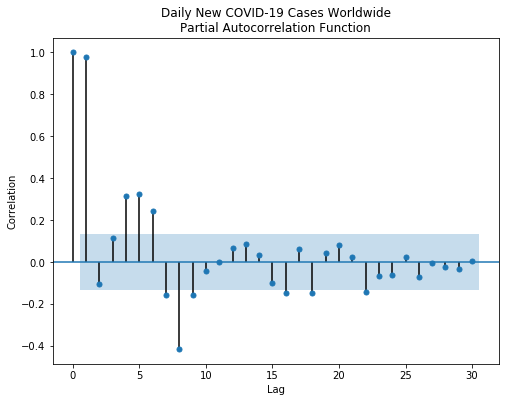

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf

ser, max_lag = load_data(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(ser, ax, lags=max_lag, title="Daily New COVID-19 Cases Worldwide\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_pacf

## Question 3: ARMA on Log Returns (10 pts)

Complete the function below that fits an $\mathrm{ARMA}(p, q)$ model on the **log return** of an input series. Your function should return a multi-day forecast in the original data space (i.e., the number of daily new cases globally) starting from `2020-08-22`. For example, if `num_forecasts=20`, your function should return a `pd.Series` similar to


```
2020-08-22    239936.746954
2020-08-23    237307.407386
2020-08-24    240073.408295
                ...
2020-09-08    279778.977067
2020-09-09    307210.157343
2020-09-10    305203.431533
Freq: D, Name: predicted_mean, dtype: float64

```

where
* the index of the series is a `pd.DatetimeIndex`; 
* the values of the series are the forecasted daily new cases; and
* the series doesn't contain any `NaN` values. 

This question is graded on the Root Mean Sqaure Error (RMSE) of your forecasts. You have complete freedom in how you'd like to implement the function, but one recommended API to use is the `ARIMA` class from the `statsmodels` library. Why do we recommend `ARIMA`, when the question actually asks for a $\mathrm{ARMA}(p, q)$ model? Hopefully you'll find it out while working on the implementation!

**This function should return a `pd.Series` of length `num_forecasts`, whose index is a `pd.DatetimeIndex`.**

### Testing Code:

In [31]:
#Take log of time series:
log_data = np.log(load_data())
log_data

date
2020-01-23     4.595120
2020-01-24     5.659482
2020-01-25     6.200509
2020-01-26     6.527958
2020-01-27     6.695799
                ...    
2020-08-17    12.253300
2020-08-18    12.449395
2020-08-19    12.522145
2020-08-20    12.495689
2020-08-21    12.508955
Length: 212, dtype: float64

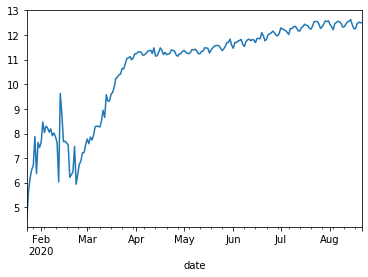

In [32]:
#Plot log of time series: 
log_data.plot()

#here I notice that log series before April is non-stationary, even after applying log transformation.

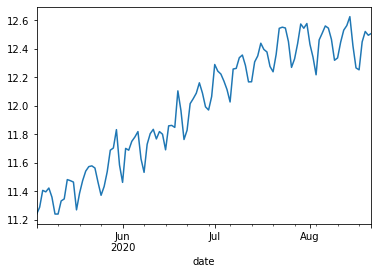

In [33]:
#If we consider last 110 days, then we can probably get rid of some of the trend, we were observaing earlier. 
log_data[-110:].plot()

In [34]:
#Import ARIMA package: 
from statsmodels.tsa.arima_model import ARIMA, ARMA
def arma_log_ret_test(ser, p, q, num_forecasts):
    
    #Prepare Data for AMRA(p,d=0,q):
    #Log return of input series: 

    log_data = np.log(ser)
    log_data.head()
    
    #Initiate ARIMA model where we will set differencing parameter D = 1 to obtain ARMA for log return time series
   
    model_arma = ARIMA(log_data, order = (p,1,q))
    
    #Train ARMA model: Here I have set transparams= False, and have set start_ar_lags = 1 
    #Trail-1:model_arma_fit = model_arma.fit(transparams=False, start_ar_lags=1) #autograder does not allow us to use these parameters. 
    
    #Trial 2: Fit ARIMA model
    model_arma_fit = model_arma.fit()
    
    
    #Forecast for next 20 days starting from 2020-08-22 and transform log return to match with the original time series. 
    forecast = np.exp(model_arma_fit.forecast(steps =num_forecasts))
    
    #Create date index starting from 2020-08-22 to 2020-09-10: 
    forecast_date_index = np.array('2020-08-22', dtype=np.datetime64)+np.arange(20)
    
    #Create forecasted date seriesL
    forecast_series = pd.Series(forecast, index= forecast_date_index)
    
    return forecast_series


In [35]:
#arma_log_ret_test(load_data(), 7, 7, 20) (don't run)

### Implementing Code: 

In [36]:
from statsmodels.tsa.arima.model import ARIMA

def arma_log_ret(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on log return. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    forecasts = None
    
    # YOUR CODE HERE
    #Prepare Data for AMRA(p,d=0,q):
    #Log return of input series: 
    log_data = np.log(ser)
    log_data.head()
    
    #Initiate ARIMA model where we will set differencing parameter D = 1 to obtain ARMA for log return time series.
    
    model_arma = ARIMA(log_data, order = (p,1,q))
    
    #Fit ARIMA model
    model_arma_fit = model_arma.fit()
    
    
    #Forecast for next 20 days starting from 2020-08-22 and transform log return to match with the original time series. 
    forecast = pd.Series(np.exp(model_arma_fit.forecast(steps =num_forecasts))).dropna()
    
    #Create date index starting from 2020-08-22 to 2020-09-10: 
    forecast_date_index = np.array('2020-08-22', dtype=np.datetime64)+np.arange(20)
    
    #Create forecasted date seriesL
    forecast_series = pd.Series(forecast, index= forecast_date_index)
    
    return forecast_series
    
    raise NotImplementedError()
    


In [37]:
arma_log_ret(load_data(), 7, 7, 20)

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2020-08-22    239936.746954
2020-08-23    237307.407386
2020-08-24    240073.408295
2020-08-25    260771.782687
2020-08-26    307479.750686
2020-08-27    319215.810028
2020-08-28    281323.660568
2020-08-29    242417.330797
2020-08-30    222517.126267
2020-08-31    238214.911303
2020-09-01    283402.826383
2020-09-02    311071.317524
2020-09-03    303034.674901
2020-09-04    274756.518566
2020-09-05    240197.755058
2020-09-06    228221.412244
2020-09-07    247180.266339
2020-09-08    279778.977067
2020-09-09    307210.157343
2020-09-10    305203.431533
Name: predicted_mean, dtype: float64

In [38]:
# Autograder tests

stu_ser = load_data()
p, q, num_forecasts = 7, 7, 20

stu_ans = arma_log_ret(stu_ser, p, q, num_forecasts)

assert isinstance(stu_ans, pd.Series), "Q3: Your function should return a pd.Series. "
assert len(stu_ans) == num_forecasts, "Q3: The length of the series returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q3: The index of your series must be a pd.DatetimeIndex. "
assert (("2020-08-22" <= stu_ans.index) & (stu_ans.index <= "2020-09-10")).all(), "Q3: The index of your series contains an incorrect time range. "
assert not stu_ans.isna().any(), "Q3: Your series contains NaN values. "

# Some hidden tests


del stu_ser, stu_ans, p, q, num_forecasts

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [39]:
model_arma = ARMA(np.log(load_data()), order = (9,9))

Now let's plot and compare the original time series, your forecasts and the ground-truth values of your forecasts. 

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


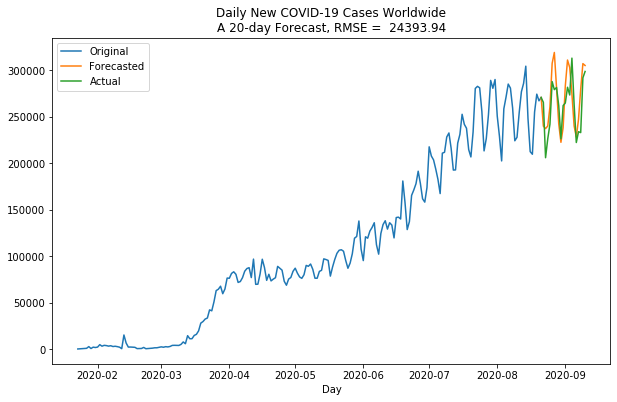

In [40]:
ser = load_data()
p, q, num_forecasts = 7, 7, 20

forecasts = arma_log_ret(ser, p, q, num_forecasts)
actual = pd.read_pickle("assets/actual.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(ser[-1:].append(forecasts), label="Forecasted")
ax.plot(ser[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual

## Question 4: ARMA on First-order Differences (10 pts)

Complete the function below that fits an $\mathrm{ARMA}(p, q)$ model on the **first-order differences** of an input series. Your function should return a multi-day forecast in the original data space (i.e., the number of daily new cases globally) starting from `2020-08-22`. For example, if `num_forecasts=20`, your function should return a `pd.Series` similar to


```
2020-08-22    242994.084820
2020-08-23    205194.792913
2020-08-24    201803.644029
                ...
2020-09-08    214574.419936
2020-09-09    243506.281330
2020-09-10    253847.751339
Freq: D, Name: predicted_mean, dtype: float64
```

where
* the index of the series is a `pd.DatetimeIndex`; 
* the values of the series are the forecasted daily new cases; and
* the series doesn't contain any `NaN` values. 

This question is graded on the Root Mean Sqaure Error (RMSE) of your forecasts. You have complete freedom in how you'd like to implement the function, but one recommended API to use is the `ARIMA` class from the `statsmodels` library. Why do we recommend `ARIMA`, when the question actually asks for a $\mathrm{ARMA}(p, q)$ model? Again, hopefully you'll find it out while working on the implementation!

**This function should return a `pd.Series` of length `num_forecasts`, whose index is a `pd.DatetimeIndex`.**

### Testing code: 

In [41]:
#First order difference can be calculated by setting D=1. So, we will take the original series and set p,d,q parameters:
load_data()

date
2020-01-23        99
2020-01-24       287
2020-01-25       493
2020-01-26       684
2020-01-27       809
               ...  
2020-08-17    209672
2020-08-18    255096
2020-08-19    274346
2020-08-20    267183
2020-08-21    270751
Length: 212, dtype: int64

In [42]:
data_diff = pd.Series((load_data()[1:].values - load_data()[:-1].values), index = load_data()[1:].index)

### Implementing Code:

In [43]:
from statsmodels.tsa.arima.model import ARIMA

def arma_first_diff(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on first-order diff. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    forecasts = None
    
    # YOUR CODE HERE
    
    #Initiate ARIMA model where we will set differencing parameter D = 1 to obtain first order ARMA model.
    model_arma = ARIMA(ser, order = (p,1,q))
    

    #Fit ARIMA model
    model_arma_fit = model_arma.fit()
    
    
    #Forecast for next 20 days starting from 2020-08-22. 
    forecast = pd.Series(model_arma_fit.forecast(steps =num_forecasts))
    
    #Create date index starting from 2020-08-22 to 2020-09-10: 
    forecast_date_index = np.array('2020-08-22', dtype=np.datetime64)+np.arange(20)
    
    #Create forecasted date seriesL
    forecast_series = pd.Series(forecast, index= forecast_date_index)
    
    return forecast_series
    raise NotImplementedError()
    

In [44]:
arma_first_diff(load_data(), 7, 7, 20)

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2020-08-22    242994.084820
2020-08-23    205194.792913
2020-08-24    201803.644029
2020-08-25    234062.883413
2020-08-26    261217.561111
2020-08-27    267464.168730
2020-08-28    256064.331459
2020-08-29    226802.088289
2020-08-30    197856.540449
2020-08-31    195818.418327
2020-09-01    222399.677772
2020-09-02    251052.707715
2020-09-03    260909.780020
2020-09-04    246186.483585
2020-09-05    215880.502976
2020-09-06    190149.187984
2020-09-07    189886.289042
2020-09-08    214574.419936
2020-09-09    243506.281330
2020-09-10    253847.751339
Name: predicted_mean, dtype: float64

In [45]:
# Autograder tests

stu_ser = load_data()
p, q, num_forecasts = 7, 7, 20

stu_ans = arma_first_diff(stu_ser, p, q, num_forecasts)

assert isinstance(stu_ans, pd.Series), "Q4: Your function should return a pd.Series. "
assert len(stu_ans) == num_forecasts, "Q4: The length of the series returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q4: The index of your series must be a pd.DatetimeIndex. "
assert (("2020-08-22" <= stu_ans.index) & (stu_ans.index <= "2020-09-10")).all(), "Q4: The index of your series contains an incorrect time range. "
assert not stu_ans.isna().any(), "Q4: Your series contains NaN values. "

# Some hidden tests


del stu_ser, stu_ans, p, q, num_forecasts

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Now let's plot and compare the original time series, your forecasts and the ground-truth values of your forecasts. How does this compare with the one trained on log returns? 

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


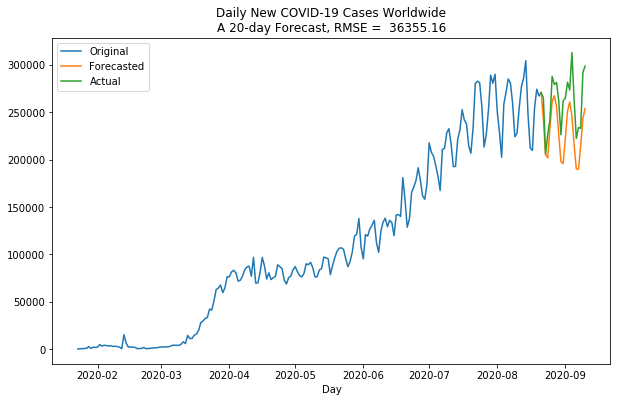

In [46]:
ser = load_data()
p, q, num_forecasts = 7, 7, 20

forecasts = arma_first_diff(ser, p, q, num_forecasts)
actual = pd.read_pickle("assets/actual.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(ser[-1:].append(forecasts), label="Forecasted")
ax.plot(ser[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual